# Wait User Input
`Human in the loop(HIL)`でキーとなる`interrupt()`を使ってGraphを中断しユーザーの入力を待つ。

- How to wait for user input using interrupt(https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/)

- `interrupt()`(https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.interrupt)
- Add human-in-the-loop interrupt(https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#interrupt)
  - ユーザーの入力を待つためにグラフを中断

### 参考
- LangGraphの(LLMなし)Human-in-the-loopを試してみた(https://qiita.com/te_yama/items/db38201af60dec76384d)

## セットアップ

In [1]:
%pip install -qU langgraph langchain-community langchain-openai tavily-python python-dotenv

Note: you may need to restart the kernel to use updated packages.


## 環境変数

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## 実装

In [16]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state: State):
    print("---Step 1---")
    pass


def human_feedback(stat: State):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")  # ユーザーの入力を待つ、ユーザーからの入力はfeedbackに格納される
    return {"user_feedback": feedback}


def step_3(state: State):
    print("---Step 3---")
    pass


builder = StateGraph(State)

builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
# builder.add_edge("step_1", "step_3")  # human_feedbackをスキップするケースの検証用
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

## グラフの描画

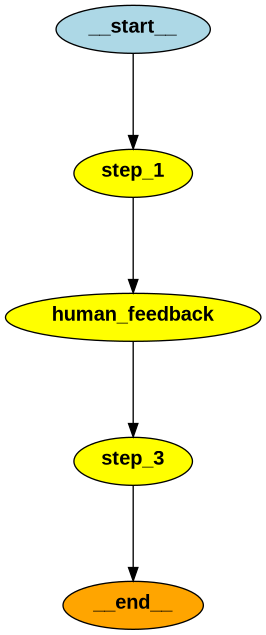

In [17]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

## 実行

### グラフに入力を与える

グラフに入力を与えると`interrupt()`を含む`human_feedback`ノードで処理が中断される。

In [8]:
import random

# Input
initial_input = {"input": "hello world"}

# Thread
num = random.randint(1, 10)
thread = {"configurable": {"thread_id": num}}

# Run the graph until the first interruption
# for event in graph.stream(initial_input, config=thread, stream_mode="updates"):
#     print(event)
    # print("\n")

# invokeで実行しても良い
graph.invoke(initial_input, config=thread)



---Step 1---
---human_feedback---
値を入力してください。
---human_feedback---
---Step 3---
{'input': 'hello world', 'user_feedback': 'OK!'}


### ユーザーの入力を与える
中断時と同じスレッドIDを与えてグラフを実行することで、中断しているグラフを再実行することができる。  
また、`Command()`を使ってユーザーからの入力を与える。  
今回は`Command()`の引数に`resume`を指定することで`State.user_feedback`を直接与えるようにしている。


Add human-in-the-loop(https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/)
> The graph is resumed using a Command object that provides the human's response.

In [ ]:
# Continue the graph execution
# for event in graph.stream(
#     Command(resume="go to step 3!"),
#     thread,
#     stream_mode="updates",
# ):
#     print(event)
#     print("\n")

# invokeで実行しても良い
graph.invoke(Command(resume="go to step 3!"), config=thread)

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




{'input': 'hello world', 'user_feedback': 'go to step 3!'}

### input()でユーザーの入力をインタラクティブに受け付ける

In [18]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

result = graph.invoke(initial_input, config=thread)

# Graphがinterruptで中断されているかをチェック
if "__interrupt__" in result and result["__interrupt__"] is not None:
    print("値を入力してください。")
    user_message = input()
    result = graph.invoke(Command(resume=user_message), config=thread)

print(result)

---Step 1---
---human_feedback---
値を入力してください。


---human_feedback---
---Step 3---
{'input': 'hello world', 'user_feedback': 'OK!'}


## メモ
次は別のBookで以下をやってみる。  
https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#agent